In [22]:
import warnings
warnings.filterwarnings('ignore')
import os

#the basics
import pandas as pd, numpy as np, seaborn as sns
import math, json
from matplotlib import pyplot as plt
from tqdm import tqdm

#for model evaluation
from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cuda')

In [24]:
os.chdir('c:\\Users\\MINSEOK\\Desktop\\대학생활\\대외활동\\kaggle\\stanford-covid-vaccine')
train=pd.read_json('train.json', lines=True)
test=pd.read_json('test.json', lines=True)
sample_sub=pd.read_csv('sample_submission.csv')


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2400 non-null   int64  
 1   id                   2400 non-null   object 
 2   sequence             2400 non-null   object 
 3   structure            2400 non-null   object 
 4   predicted_loop_type  2400 non-null   object 
 5   signal_to_noise      2400 non-null   float64
 6   SN_filter            2400 non-null   int64  
 7   seq_length           2400 non-null   int64  
 8   seq_scored           2400 non-null   int64  
 9   reactivity_error     2400 non-null   object 
 10  deg_error_Mg_pH10    2400 non-null   object 
 11  deg_error_pH10       2400 non-null   object 
 12  deg_error_Mg_50C     2400 non-null   object 
 13  deg_error_50C        2400 non-null   object 
 14  reactivity           2400 non-null   object 
 15  deg_Mg_pH10          2400 non-null   o

In [26]:
num_col=[]
cat_col=[]

for col in train.columns:
    if train[col].dtype=='object':
        cat_col.append(col)
    else:
        num_col.append(col)
        
print(cat_col)

cat_col.remove('id')

['id', 'sequence', 'structure', 'predicted_loop_type', 'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']


<Axes: xlabel='SN_filter', ylabel='count'>

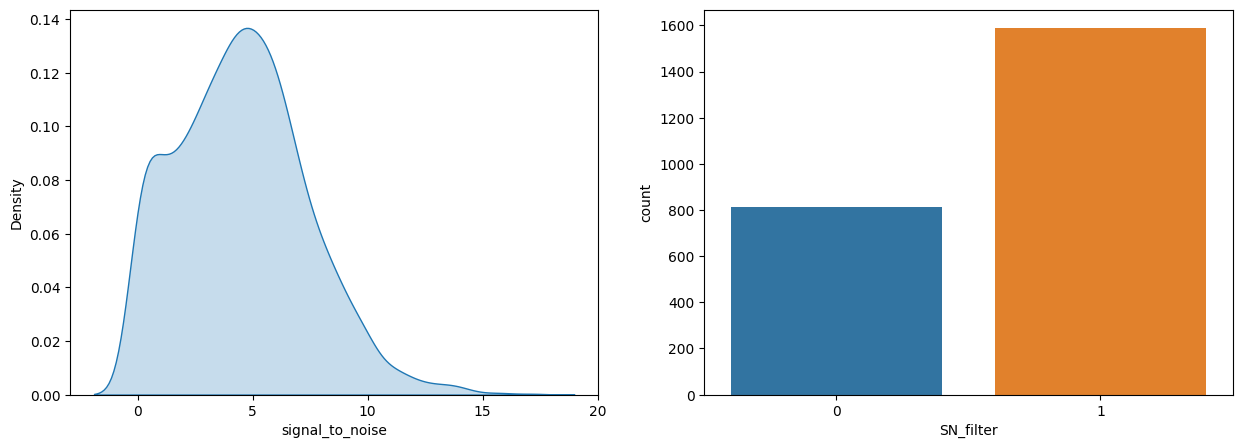

In [27]:
# Mean signal/noise across all 5 conditions must be greater than 1.0
# Signal/noise is defined as mean( measurement value over 68 nts )/mean( statistical error in measurement value over 68 nts)

fig, ax=plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(train['signal_to_noise'], shade=True, ax=ax[0])
sns.countplot(x='SN_filter', data=train, ax=ax[1])


In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3634 entries, 0 to 3633
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                3634 non-null   int64 
 1   id                   3634 non-null   object
 2   sequence             3634 non-null   object
 3   structure            3634 non-null   object
 4   predicted_loop_type  3634 non-null   object
 5   seq_length           3634 non-null   int64 
 6   seq_scored           3634 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 198.9+ KB


In [29]:
sample_sub.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


In [30]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [31]:
train[['sequence','structure','predicted_loop_type']]

,sequence,structure,predicted_loop_type
0,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
1,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...
2,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...
3,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...
4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...
...,...,...,...
2395,GGAAAAUAGCAGAGGAAAUACUAGAGCAAUUGCAAAGGCCGAUCAU...,........((..((......))...)).........(((..........,EEEEEEEESSIISSHHHHHHSSIIISSXXXXXXXXXSSSHHHHHHH...
2396,GGAAAACAAAAACAAACAACAAAAACAAACAACAAAAACAAACAAC...,.................................................,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...
2397,GGAAAGCCAUACCUAGGCUUCGGCCUAGGUAUGGCGGUGAUCUGGU...,.....(((((((((((((....)))))))))))))(((((((((((...,EEEEESSSSSSSSSSSSSHHHHSSSSSSSSSSSSSSSSSSSSSSSS...
2398,GGAAACGAUAGCAGAAGAGAUCGAUAUAGAGCAUAAGCUAAGAAUA...,.....((((..(....)..))))......(((....)))..........,EEEEESSSSIISHHHHSIISSSSXXXXXXSSSHHHHSSSXXXXXXX...


In [32]:
# encoding catagorical data into integer 
# seperating each char of string data in cat data and covert to int
# (encoding reference :token2int -> dict)

token2int={x:i for i,x in enumerate('().ACGUBEHIMSX')}
print(token2int) 

def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )


{'(': 0, ')': 1, '.': 2, 'A': 3, 'C': 4, 'G': 5, 'U': 6, 'B': 7, 'E': 8, 'H': 9, 'I': 10, 'M': 11, 'S': 12, 'X': 13}


In [33]:
# why transpose? (data_count, structure_protein(A,C,G,U)_count, column_count)

train_filtered = train.loc[train.SN_filter == 1]
train_inputs = torch.tensor(preprocess_inputs(train_filtered)).to(device)
print("input shape: ", train_inputs.shape)
train_labels = torch.tensor(
    np.array(train_filtered[target_cols].values.tolist()).transpose(0, 2, 1)
).float().to(device)
print("output shape: ", train_labels.shape)

input shape:  torch.Size([1589, 107, 3])
output shape:  torch.Size([1589, 68, 5])


In [34]:
np.array(train[target_cols].values.tolist()).shape

(2400, 5, 68)

In [35]:
np.array(train[target_cols].values.tolist())[0]

array([[0.3297, 1.5693, 1.1227, 0.8686, 0.7217, 0.4384, 0.256 , 0.3364,
        0.2168, 0.3583, 0.9541, 1.4113, 1.6911, 1.2494, 1.1895, 0.6909,
        0.4736, 0.1754, 0.0582, 0.2173, 0.0785, 0.8249, 0.7638, 0.1095,
        0.2568, 0.0895, 0.1576, 0.7727, 0.1573, 0.5043, 1.0444, 0.4766,
        0.5588, 0.9054, 1.0125, 1.0482, 1.044 , 0.4522, 0.211 , 0.0461,
        0.082 , 0.0643, 0.1526, 0.0894, 0.5081, 1.0745, 0.3215, 0.0716,
        0.0244, 0.0123, 0.1984, 0.4961, 1.0641, 0.6394, 0.6789, 0.365 ,
        0.1741, 0.1408, 0.1646, 0.5389, 0.683 , 0.4273, 0.0527, 0.0693,
        0.1398, 0.2937, 0.2362, 0.5731],
       [0.7556, 2.983 , 0.2526, 1.3789, 0.6376, 0.3313, 0.6763, 0.7525,
        0.208 , 0.8908, 0.9898, 0.8679, 1.7403, 1.3795, 0.7746, 0.719 ,
        0.7229, 0.4069, 0.2632, 0.3631, 0.0702, 0.4765, 0.2766, 0.4936,
        0.4379, 0.3261, 0.0898, 0.4159, 0.2264, 0.4142, 0.5213, 0.2653,
        0.3163, 0.9059, 0.8762, 0.8991, 0.7262, 0.4762, 0.1187, 0.1952,
        0.1777, 0.1281,

Define GRU estimator (bidirectional) 
====================

In [36]:
# embed_size : depends on which encoding model you used
# in this practice, i used custom encoding model(token2int)
# free to use any encoding dimension 

class GRU_model(nn.Module):
    def __init__(
        self, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100,
        hidden_dim=128, hidden_layers=3
    ):
        super(GRU_model,self).__init__()
        self.pred_len=pred_len
        
        self.embedding=nn.Embedding(num_embeddings=len(token2int),
                                    embedding_dim=embed_dim)
        
        self.gru=nn.GRU(
# input_size : feature num. why multiply 3?
            input_size=embed_dim*3,
            hidden_size=hidden_dim,
            num_layers=hidden_layers,
            dropout=dropout,
            # why bidirectional?
            bidirectional=True,
            
            # (data_count, structure_protein(A,C,G,U)_count, column_count)
            # first dim is batch size
            batch_first=True
        )
        
        # why hidden_dim*2? / output is 5
        self.linear=nn.Linear(hidden_dim*2, 5)
        
    def forward(self, seqs):
        embed=self.embedding(seqs)
        reshaped=torch.reshape(embed, (-1, embed.shape[1],
                                       embed.shape[2]*embed.shape[3]))
        output, hidden=self.gru(reshaped)
        # since public leaderboard only require prediction for first 68 structures
        # :self.pred_len
        truncated=output[:,:self.pred_len,:]
        
        out=self.linear(truncated)
        
        return out
    

Define LSTM estimator (bidirectional)
======================

In [37]:
class LSTM_model(nn.Module):
    def __init__(
        self, seq_len=107, pred_len=68, dropout=0.5, embed_dim=100,
        hidden_dim=128, hidden_layers=3
    ):
        # inherit nn.modules to class LSTM_model
        super(LSTM_model,self).__init__()
        self.pred_len=pred_len
        self.embedding=nn.Embedding(num_embeddings=len(token2int)
                                    ,embedding_dim=embed_dim)
        self.lstm=nn.LSTM(
            input_size=embed_dim*3,
            hidden_size=hidden_dim,
            num_layers=hidden_layers,
            dropout=dropout,
            bidirectional=True,
            batch_first=True
        )
        self.linear=nn.Linear(hidden_dim*2, 5)
        
        
    def forward(self,seqs):
        embed=self.embedding(seqs)
        reshaped=torch.reshape(embed,(-1,embed.shape[1],
                                      embed.shape[2]*embed.shape[3]))
        output=self.lstm(reshaped)
        truncated=output[:,:self.pred_len,:]
        out=self.linear(truncated)
        return out
        

Defining Loss Function (MSE)
===========================

In [38]:
# error 1. 바로 nn.MSELoss 쓰면 왜 안되는지

# training phase vs validation phase vs test phase
# In training phase -> model.train(True)
# In validation phase -> model.train(False)
# In testing phase -> model.eval()

mse_loss=nn.MSELoss()

def compute_loss(batch_X, batch_Y, model, optimizer=None, is_train=True):
    
    model.train(is_train)
    pred_Y=model(batch_X)
        
    loss=mse_loss(pred_Y,batch_Y)
    
    if is_train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss.item()

Data Splitting & Base Parameters
======================

In [39]:
Folds=4
Epochs=90
Batch_Size=64
Verbose=2
lr=0.01

In [40]:
# TensorDataset : wrapping tensor data. ex)zip()
# returns each sample by indexing from first dim 

public_df=test.query("seq_length==107").copy()
private_df=test.query("seq_length==130").copy()

# diffrence of torch.Tensor vs torch.tensor
# torch.Tensor : class, does not need data as input (empty tensor)
# torch.tensor : function, need data as input
public_inputs=torch.tensor(preprocess_inputs(public_df)).to(device)
private_inputs=torch.tensor(preprocess_inputs(private_df)).to(device)

public_loader=DataLoader(TensorDataset(public_inputs),
                         shuffle=True, batch_size=Batch_Size)
private_loader=DataLoader(TensorDataset(private_inputs),
                         shuffle=True, batch_size=Batch_Size)



Training & Inference (GRU)
=========================

In [41]:
# original

gru_histories=[]
gru_private_preds=np.zeros((private_df.shape[0], 130, 5))
gru_public_preds=np.zeros((public_df.shape[0], 107, 5))

kf=KFold(Folds, shuffle=True)

for k, (train_index, val_index) in enumerate(kf.split(train_inputs)):
    train_datasets=TensorDataset(train_inputs[train_index],
                                 train_labels[train_index])
    
    val_datasets=TensorDataset(train_inputs[val_index],
                                train_labels[val_index])
    
    train_loader=DataLoader(train_datasets, batch_size=Batch_Size,
                            shuffle=True)
    
    val_loader=DataLoader(val_datasets, batch_size=Batch_Size,
                            shuffle=False)
    
    model=GRU_model().to(device)
    optimizer=optim.Adam(model.parameters(), lr=lr)
    
    train_losses=[]
    val_losses=[]
    
    for epoch in tqdm(range(Epochs)):
        train_losses_batch=[]
        val_losses_batch=[]
        for (batch_X, batch_Y) in train_loader:
            train_loss=compute_loss(batch_X,batch_Y,
                                    model=model,optimizer=optimizer
                                    , is_train=True)
            train_losses_batch.append(train_loss)

        for (batch_X, batch_Y) in val_loader:
            val_loss=compute_loss(batch_X,batch_Y,
                                    model=model,optimizer=optimizer
                                    , is_train=False)
            val_losses_batch.append(val_loss)
        
        train_losses.append(sum(train_losses_batch)/len(train_losses_batch))        
        val_losses.append(sum(val_losses_batch)/len(val_losses_batch))
        
        #save current trained model by state_dict()
        
    model_state=model.state_dict()

    del model
    
    # training phase end.
    
    # testing with public test data and private test data

        
    gru_histories.append({"train_loss":train_losses, 'val_loss':val_losses})
    
    gru_short=GRU_model(seq_len=107, pred_len=107).to(device)
    gru_short.load_state_dict(model_state)
    # .eval() vs .inference_mode() ?
    gru_short.eval()
    # np.ndarray((107,5)) is not ok?
    gru_public_pred=np.ndarray((0,107,5))
    for batch in public_loader:
        batch_X=batch[0]
        pred=gru_short(batch_X).detach().cpu().numpy()
        gru_public_pred=np.concatenate([gru_public_pred,pred], axis=0)
    gru_public_preds+=gru_public_pred/Folds
    

    gru_long=GRU_model(seq_len=130, pred_len=130).to(device)
    gru_long.load_state_dict(model_state)
    # .eval() vs .inference_mode() ?
    gru_long.eval()
    # np.ndarray((107,5)) is not ok?
    gru_private_pred=np.ndarray((0,130,5))
    for batch in private_loader:
        batch_X=batch[0]
        pred=gru_long(batch_X).detach().cpu().numpy()
        gru_private_pred=np.concatenate([gru_private_pred,pred], axis=0)
    gru_private_preds+=gru_private_pred/Folds
    
    del gru_long, gru_short
    


100%|██████████| 90/90 [00:15<00:00,  5.69it/s]


In [42]:
print(f" GRU mean fold validation loss: {np.mean([min(history['val_loss']) for history in gru_histories])}")

 GRU mean fold validation loss: 0.09145521957959449


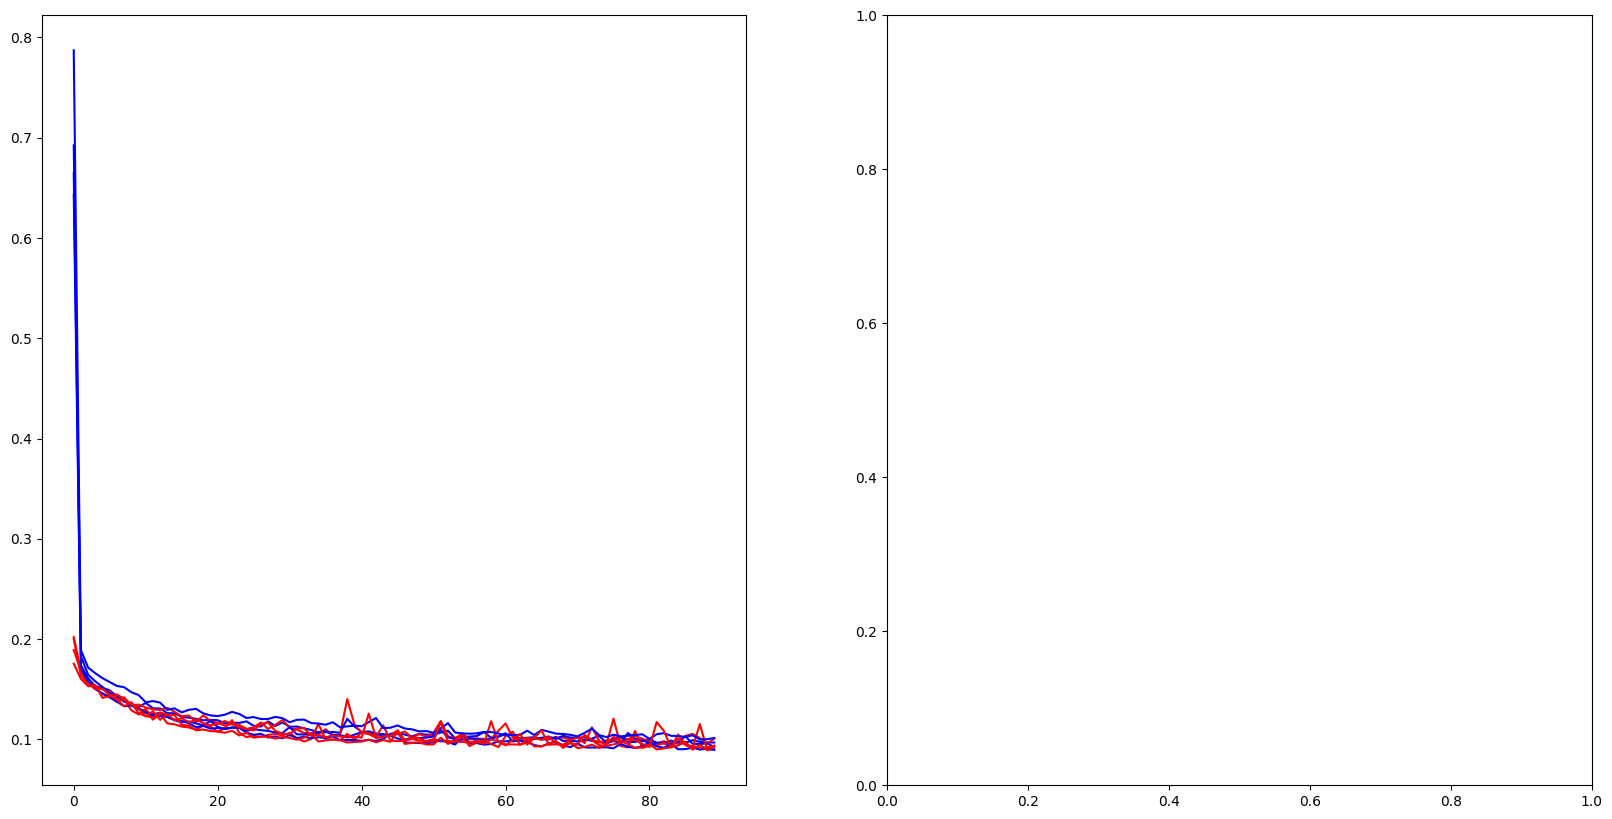

In [43]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

for history in gru_histories:
    ax[0].plot(history['train_loss'], 'b')
    ax[0].plot(history['val_loss'], 'r')